# Maze Experiment Introduction

In this notebook, we will be running the MDP_Model on the Maze problem. This 2D simulation builds on a `gym-maze` package that can be found here: https://github.com/MattChanTK/gym-maze. Before beginning this simulation, please be sure to install the relevant packages on the github **Installation** section (pygame and numpy are also required)!

## Running the Algorithm - Optimal Clustering 5x5

We can generate bigger mazes using the same method as above! Then, we will test to see if the optimal policy found by the maze is the same as the real optimal policy. 

#### Importing Modules

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import gym
import gym_maze

import sys
sys.path.append('/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/')

from model import MDP_model
from maze_functions import createSamples, opt_maze_trajectory, opt_model_trajectory, policy_accuracy, \
    get_maze_transition_reward, plot_paths
from testing import cluster_size, next_clusters, training_value_error, purity, plot_features, testing_value_error

mazes = {1: 'maze-v0',
         2: 'maze-sample-3x3-v0',
         3: 'maze-random-3x3-v0',
         4: 'maze-sample-5x5-v0',
         5: 'maze-random-5x5-v0',
         6: 'maze-sample-10x10-v0',
         7: 'maze-random-10x10-v0',
         8: 'maze-sample-100x100-v0',
         9: 'maze-random-100x100-v0',
         10: 'maze-random-10x10-plus-v0', # has portals 
         11: 'maze-random-20x20-plus-v0', # has portals 
         12: 'maze-random-30x30-plus-v0'} # has portals 

#### Creating Samples

In [16]:
# Setting Parameters
N = 150
T_max = 25
r = 0.5
maze = mazes[4]

In [17]:
df = createSamples(N, T_max, maze, r, reseed=True)
df

,ID,TIME,FEATURE_0,FEATURE_1,ACTION,RISK,OG_CLUSTER
0,0,0,0.911789,-0.514672,3,-0.004,0
1,0,1,0.785051,-0.101153,0,-0.004,0
2,0,2,0.481780,-0.205181,2,-0.004,0
3,0,3,1.573666,-0.699118,2,-0.004,1
4,0,4,2.001718,-0.503802,1,-0.004,2
...,...,...,...,...,...,...,...
3588,149,20,3.792823,-1.575549,2,-0.004,8
3589,149,21,4.773804,-1.539997,1,-0.004,9
3590,149,22,4.814392,-2.662272,0,-0.004,14
3591,149,23,4.875858,-1.437368,1,-0.004,9


That's how the transition data looks like:

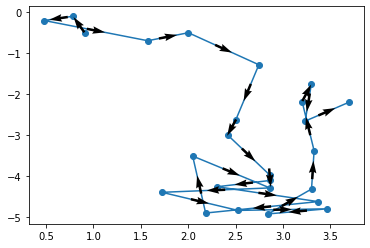

In [18]:
plot_paths(df,1)

Checking how many points actually reach the end: 

In [19]:
df.loc[df['ACTION']=='None']['ID'].count()

59

#### Fitting to Algorithm

Splitting... |#Clusters:2:   0%|          | 0/20 [00:00<?, ?it/s]

Clusters Initialized
       ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0       0     0   0.911789  -0.514672      3 -0.004           0        0   
1       0     1   0.785051  -0.101153      0 -0.004           0        0   
2       0     2   0.481780  -0.205181      2 -0.004           0        0   
3       0     3   1.573666  -0.699118      2 -0.004           1        0   
4       0     4   2.001718  -0.503802      1 -0.004           2        0   
...   ...   ...        ...        ...    ...    ...         ...      ...   
3588  149    20   3.792823  -1.575549      2 -0.004           8        0   
3589  149    21   4.773804  -1.539997      1 -0.004           9        0   
3590  149    22   4.814392  -2.662272      0 -0.004          14        0   
3591  149    23   4.875858  -1.437368      1 -0.004           9        0   
3592  149    24   4.535268  -2.957843      3 -0.004          14        0   

     NEXT_CLUSTER  
0               0  
1               0  
2     

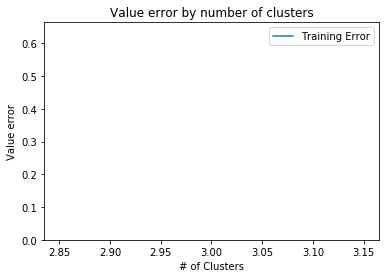

Splitting... |#Clusters:20:  90%|█████████ | 18/20 [01:10<00:08,  4.16s/it]/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Splitting... |#Clusters:21:  95%|█████████▌| 19/20 [01:15<00:04,  4.40s/it]/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Splitting... |#Clusters:21:  95%|█████████▌| 19/20 [01:20<00:04,  4.23s/it]

Optimal # of clusters reached


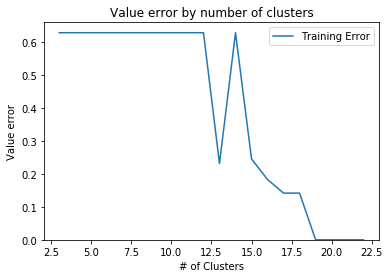

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [20]:
# Setting parameters for model fitting
max_k = 22
classification = 'DecisionTreeClassifier'
split_classifier_params = {'random_state':0, 'max_depth':2}
clustering = 'Agglomerative'
n_clusters = None
distance_threshold = 0.5
random_state = 0
pfeatures = 2
gamma = 1
actions = [0, 1, 2, 3]
h = -1
cv = 5
th = 0

m = MDP_model()
m.fit(df, # df: dataframe in the format ['ID', 'TIME', ...features..., 'RISK', 'ACTION']
    pfeatures, # int: number of features
    h, # int: time horizon (# of actions we want to optimize)
    gamma, # discount factor
    max_k, # int: number of iterations
    distance_threshold, # clustering diameter for Agglomerative clustering
    cv, # number for cross validation
    th, # splitting threshold
    classification, # classification method
    split_classifier_params, # classifier params
    clustering,# clustering method from Agglomerative, KMeans, and Birch
    n_clusters, # number of clusters for KMeans
    random_state,
    plot=True,
    optimize=False)

### Errors

In [24]:
# In sample training value error: 
m.training_error['Error'].iloc[-1]

1.0809243727453476e-17

Now, we will generate a new unseen test set using optimal parameters, and see how well the model does. This is the testing accuracy. 

In [32]:
# Creating a test set -- how many samples? Results range from 1.08e-17 to 0.0819
df_test = createSamples(N, T_max, maze, r, reseed=True)

# Out of sample testing value error: 
testing_value_error(df_test, m.df_trained, m.m, m.pfeatures, gamma, relative=False, h=-1)

1.0868472903575297e-17

Here is a metric that measures how good our classification model is in putting points in the right cluster:

In [34]:
m.clus_pred_accuracy

0.9991650431394378

Going through each point in the training data set, here is how many (by percentage) our optimal policy actually returned the correct action for. This is essentially the training accuracy:

In [38]:
# in sample policy accuracy (comparing model suggestion to true optimal)
policy_accuracy(m, maze, m.df_trained)

Optimal Value: [7.04370331e-01 7.22826868e-01 7.41660069e-01 8.84704957e-01
 9.06841793e-01 6.51186120e-01 7.04370331e-01 7.60877622e-01
 9.06841793e-01 9.29430401e-01 6.68557266e-01 6.86282924e-01
 7.80487369e-01 8.84704957e-01 9.52480001e-01 7.60877622e-01
 7.80487369e-01 8.00497316e-01 8.63010858e-01 9.76000001e-01
 7.41660069e-01 8.00497316e-01 8.20915628e-01 8.41750641e-01
 1.00000000e+00 9.55885364e-10]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 0 0]


0.986362371277484

In [39]:
# out of sample policy accuracy (comparing model suggestion to true optimal)
policy_accuracy(m, maze, df_test)

Optimal Value: [7.04370331e-01 7.22826868e-01 7.41660069e-01 8.84704957e-01
 9.06841793e-01 6.51186120e-01 7.04370331e-01 7.60877622e-01
 9.06841793e-01 9.29430401e-01 6.68557266e-01 6.86282924e-01
 7.80487369e-01 8.84704957e-01 9.52480001e-01 7.60877622e-01
 7.80487369e-01 8.00497316e-01 8.63010858e-01 9.76000001e-01
 7.41660069e-01 8.00497316e-01 8.20915628e-01 8.41750641e-01
 1.00000000e+00 9.55885364e-10]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 0 0]


0.9860724233983287

#### Observing Policies

First, let's see what the clustering that the model found actually looks like!

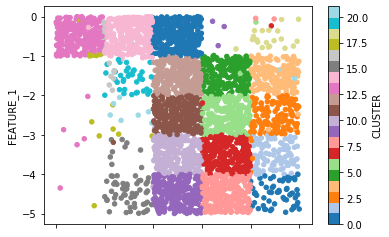

In [33]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', 'CLUSTER')

And compare it with a clustering with the actual cells of the Maze.

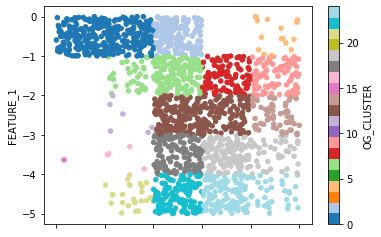

In [20]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', 'OG_CLUSTER')

In [49]:
def plot_features(df, x, y, c='CLUSTER'):
    df.plot.scatter(x=x,
                      y=y,
                      c=c,
                      colormap='tab20')
#    import seaborn as sns
#    sns.pairplot(x_vars=["FEATURE_1"], y_vars=["FEATURE_2"], data=df, hue="OG_CLUSTER", height=5)
    plt.show()

Now, let's see what the optimal policy our model learns is:

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:329: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:359: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  1.97918642e-01  2.24354046e-01  3.62917309e-01
  1.97918642e-01  1.97918642e-01  6.42344000e-01  1.97918642e-01
  1.74126777e-01  6.42344000e-01  8.31806849e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 2 2 2 0 2 1 0 0 1 0 0]


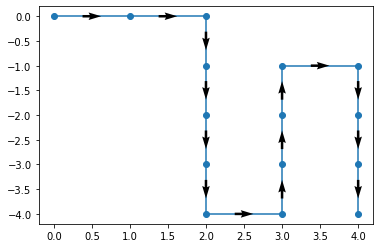

(array([0., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4., 4., 4.]),
 array([-0.,  0.,  0., -1., -2., -3., -4., -4., -3., -2., -1., -1., -2.,
        -3., -4.]))

In [35]:
opt_model_trajectory(m, maze, 5, 0.7)

And here is an actual simulation of a point through the maze by taking the found optimal policy. Note that we have set a sink node as the bottom left corner, which is where the path will go once it has reached the goal state.

states [[array([13]), 2], [array([14]), 2], [array([0]), 1], [array([12]), 1], [array([11]), 1], [array([10]), 1], [array([9]), 2], [array([8]), 0], [array([7]), 0], [array([6]), 0], [array([5]), 2], [array([4]), 1], [array([3]), 1], [array([2]), 1], [array([1]), 0]]


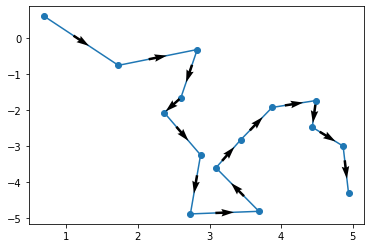

(array([0.69304435, 1.72851564, 2.82892641, 2.60052804, 2.36849543,
        2.87557   , 2.7333328 , 3.6899562 , 3.08978729, 3.43306146,
        3.87330263, 4.48547875, 4.43351966, 4.863968  , 4.93976283]),
 array([ 0.61523623, -0.75273995, -0.31202058, -1.65577842, -2.07039072,
        -3.24985406, -4.89237451, -4.81979297, -3.60719747, -2.8326212 ,
        -1.92565809, -1.73336338, -2.47601955, -3.00290103, -4.31117164]))

In [36]:
f, r = get_maze_transition_reward(maze)
x0= np.random.rand(2)
m.opt_model_trajectory(x0, f)

And finally, here is the optimal policy for reference:

Optimal Value: [7.04370331e-01 7.22826868e-01 7.41660069e-01 8.84704957e-01
 9.06841793e-01 6.51186120e-01 7.04370331e-01 7.60877622e-01
 9.06841793e-01 9.29430401e-01 6.68557266e-01 6.86282924e-01
 7.80487369e-01 8.84704957e-01 9.52480001e-01 7.60877622e-01
 7.80487369e-01 8.00497316e-01 8.63010858e-01 9.76000001e-01
 7.41660069e-01 8.00497316e-01 8.20915628e-01 8.41750641e-01
 1.00000000e+00 9.55885364e-10]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 0 0]


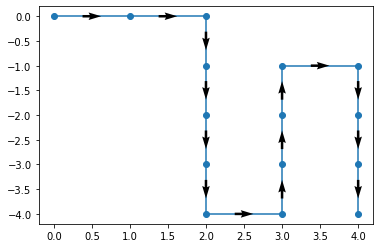

(array([0., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4., 4., 4.]),
 array([-0.,  0.,  0., -1., -2., -3., -4., -4., -3., -2., -1., -1., -2.,
        -3., -4.]))

In [35]:
opt_maze_trajectory(maze)

## Consolidating